# 1. Data Source and Contents

In [1]:
# import pandas package
import pandas as pd

# read data
census = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")

# 2. Data Quality Analysis (DQA)

In [2]:
# check how many non-null objects are in each column
# can also compare to the number of entries to see if there's any null values
print(census.info())
# no null values because non-null objects = number of entries

# see the structure of the data by looking at the first 5 rows
census.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
hours_per_week_bin    48842 non-null object
occupation_bin        48842 non-null object
msr_bin               48842 non-null object
capital_gl_bin        48842 non-null object
race_sex_bin          48842 non-null object
education_num_bin     48842 non-null object
education_bin         48842 non-null object
workclass_bin         48842 non-null object
age_bin               48842 non-null object
flag                  48842 non-null object
y                     48842 non-null int64
dtypes: int64(1), object(10)
memory usage: 4.1+ MB
None


hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
0           b. 31-40   b. Mid - Low   b. Mid         c. > 0      c. High   
1            a. 0-30        e. High  c. High         a. = 0      c. High   
2           b. 31-40         a. Low   b. Mid         a. = 0      c. High   
3           b. 31-40         a. Low  c. High         a. = 0       b. Mid   
4           b. 31-40        e. High  c. High         a. = 0       a. Low   

  education_num_bin education_bin workclass_bin            age_bin   flag  y  
0             c. 13  c. Bachelors     b. income   d. 36-40 & 56-60  train  0  
1             c. 13  c. Bachelors     b. income           e. 40-55  train  0  
2           b. 9-12        b. Mid     b. income   d. 36-40 & 56-60  train  0  
3            a. 0-8        a. Low     b. income           e. 40-55  train  0  
4             c. 13  c. Bachelors     b. income  b. 26-30 & 71-100  train  0

In [3]:
# change the type of column "y" because 0 and 1 in this case are categories, it does not have a numerical meaning
census["y"]=census["y"].astype('category')

# general data description 
# "include" argument says that we should include columns with string/object and category data types
census.describe(include=['O','category'])

hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
count               48842          48842    48842          48842        48842   
unique                  5              5        3              3            3   
top              b. 31-40   c. Mid - Mid  c. High         a. = 0      c. High   
freq                26639          13971    22047          42525        29737   

       education_num_bin education_bin workclass_bin   age_bin   flag      y  
count              48842         48842         48842     48842  48842  48842  
unique                 5             5             2         5      2      2  
top              b. 9-12        b. Mid     b. income  e. 40-55  train      0  
freq               30324         30324         46012     13963  32561  37155

In [4]:
# we want to get rid of the preceeding letters (i.e. "a. ", "b. ", etc.)
# all columns except "flag" and "y" have preceeding letters
for col in census.drop(columns=["flag","y"]): # for all columns except "flag" and "y"
    census[col] = census[col].str.split(". ", n=1, expand=True)[1] # split each value and only take the second element

In [5]:
# look at the modified dataframe
census.head()

hours_per_week_bin occupation_bin msr_bin capital_gl_bin race_sex_bin  \
0              31-40      Mid - Low     Mid            > 0         High   
1               0-30           High    High            = 0         High   
2              31-40            Low     Mid            = 0         High   
3              31-40            Low    High            = 0          Mid   
4              31-40           High    High            = 0          Low   

  education_num_bin education_bin workclass_bin         age_bin   flag  y  
0                13     Bachelors        income   36-40 & 56-60  train  0  
1                13     Bachelors        income           40-55  train  0  
2              9-12           Mid        income   36-40 & 56-60  train  0  
3               0-8           Low        income           40-55  train  0  
4                13     Bachelors        income  26-30 & 71-100  train  0

# 3. Exploratory Data Analysis (EDA)

In [6]:
# import necessary packages
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

# create a function to create plot, col_name argument takes the input of any column name in our census data
def create_plot(col_name):
    # create a pivot table from the data: 
    # the rows would be the different categories in the specified column
    # the columns would be the value 0 and 1 from the "y" column
    # the pivot_table function would create these for each variable in the census data (excluding the specified column)
    # however, since we are only counting the amount of records, all of the count of 0 and 1 from column "y" would be the same
    # so for this case, we will select the "flag" column (can be any other column)
    table_var = pd.pivot_table(data=census, index=col_name, columns="y",aggfunc="count")["flag"]
    # we divide the count for each values of y (0 and 1) by the total amount of records for each unique categories in the specified column
    # then, we multiply these values by 100, so it would show the percentage of records in which are 0 or 1 in each unique categories 
    table_var = table_var.div(table_var.sum(axis=1),axis=0).apply(lambda x: x*100).sort_values(by=[1])
    # finally, we plot our values in a stacked bar chart
    table_plot = table_var.plot.bar(stacked=True,color=['steelblue','darkorange'])
    # specify the legend location to be outside of the plot
    table_plot.legend(bbox_to_anchor=(1.01, 0.6))
    # show the plot
    plt.show()

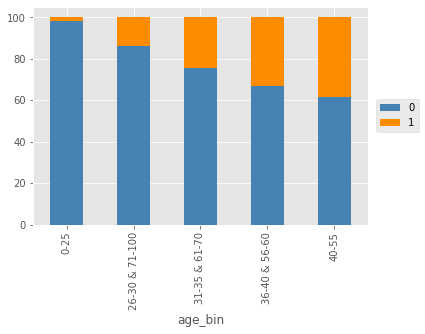

In [7]:
create_plot("age_bin")

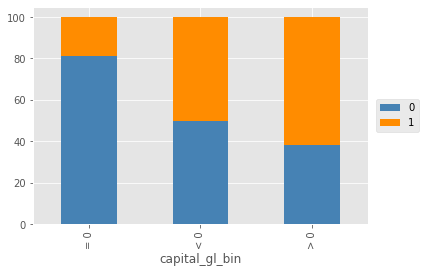

In [8]:
create_plot("capital_gl_bin")

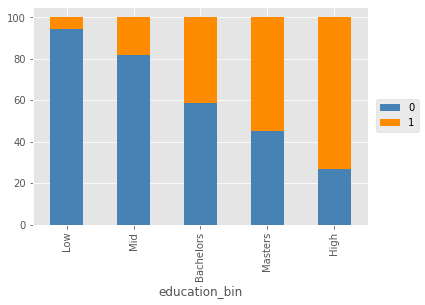

In [9]:
create_plot("education_bin")

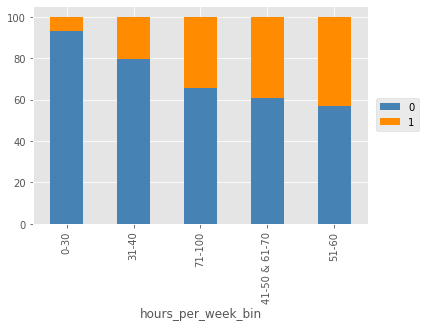

In [10]:
create_plot("hours_per_week_bin")

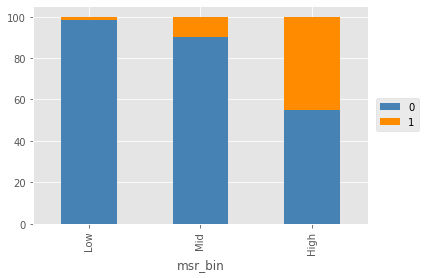

In [11]:
create_plot("msr_bin")

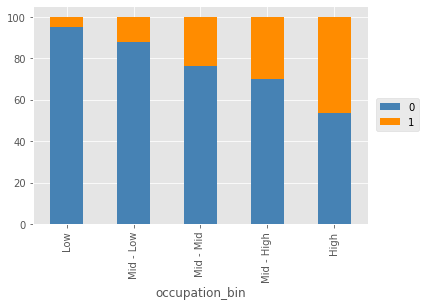

In [12]:
create_plot("occupation_bin")

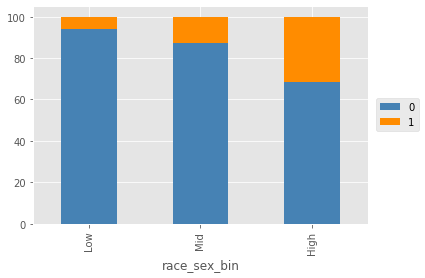

In [13]:
create_plot("race_sex_bin")

# 4. Build Decision Tree Classifier

In [14]:
# import necessary packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import time

# divide our dataset into train and test set
# we want to drop education_num_bin along with the flag column,
# because education_num_bin and education_bin represent the same attribute
train = census[census["flag"]=="train"].drop(["flag","education_num_bin"],axis=1)
test = census[census["flag"]=="test"].drop(["flag","education_num_bin"],axis=1)
x_train = train.drop("y",axis=1)
y_train = train["y"]
x_test = test.drop("y",axis=1)
y_test = test["y"]

# create dummy variables for each of the categorical columns using OneHotEncoder
encoder = OneHotEncoder()
x_train = encoder.fit_transform(x_train).toarray()
x_test = encoder.fit_transform(x_test).toarray()

# we use this to track the time it takes to train the model
# this tells our program to start track the current time
start = time.time()
# instantiate the decision tree classifier using the specified hyperparameters
dtree = DecisionTreeClassifier(max_depth=5, random_state=23,
                               max_features=None, min_samples_leaf=15)
# fit the training set into the model
dtree.fit(x_train, y_train)
# track the current time and subtract it with the tracked start time
# this is the time elapsed since we instantiate the model
elapsed = time.time()-start
print("Time it takes to train the model: {} seconds.".format(elapsed))

# predict the test set and save the labels into variable y_pred
y_pred = dtree.predict(x_test)

Time it takes to train the model: 0.035980224609375 seconds.


# 5. Visualize Decision Tree using GraphViz

/Users/vrevelina/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


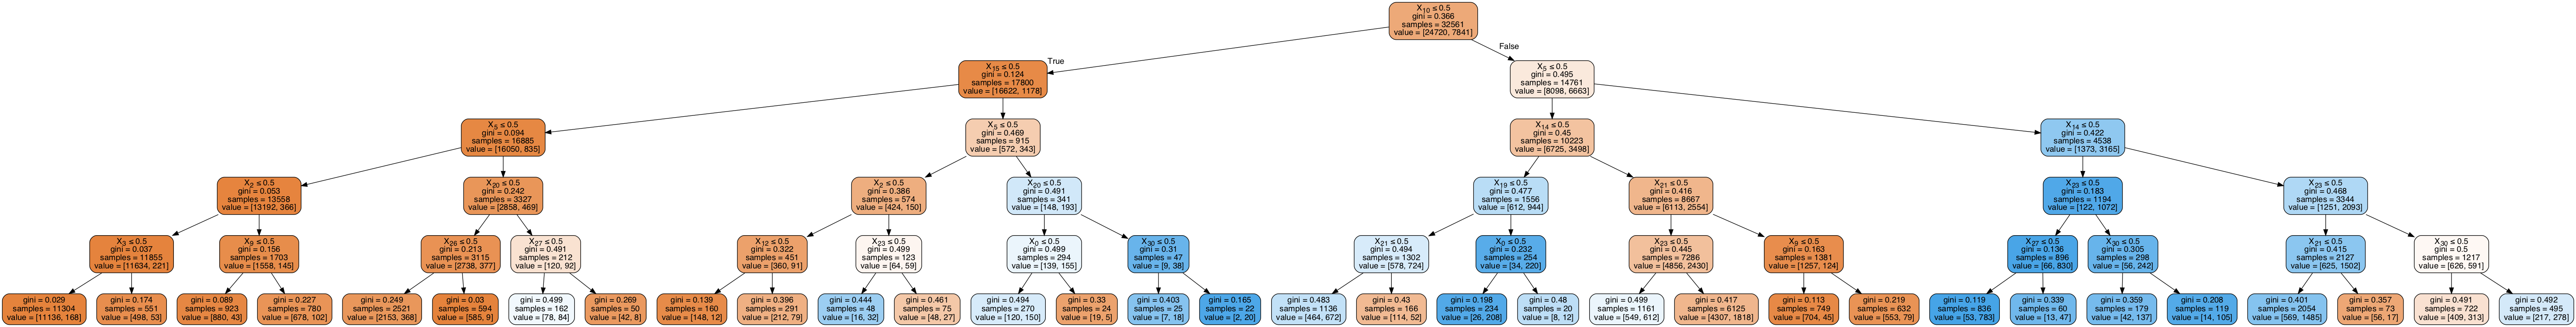

In [15]:
# import necessary packages
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# 6. Evaluate Decision Tree Performance

true negatives: 11355
false positives: 1080
false negatives: 1594
true positives: 2252
precision: 0.68
recall: 0.59
f1-score: 0.63
support: 3846
Accuracy score: 0.8357594742337694
AUC (Area Under Curve): 0.8742092056018389


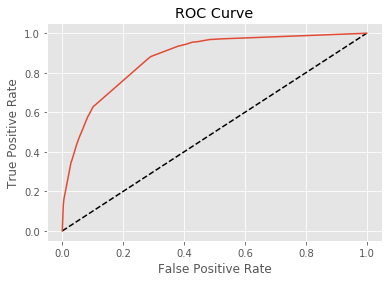

In [16]:
# import necessary packages
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

# create a confusion matrix based on our actual y labels and predicted y labels
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
confmatstr = ["true negatives", "false positives", "false negatives", "true positives"]
confmat = [tn, fp, fn, tp]
# print the counts
for i in range(len(confmat)):
    print("{}: {}".format(confmatstr[i],confmat[i]))

print("===================================")

# create an array of measure values
measures = precision_recall_fscore_support(y_test,y_pred)
measure_names = ["precision:","recall:","f1-score:","support:"]
# print the measure values
for i in range(len(measures)):
    print(measure_names[i],np.round(measures[i][1],2))

print("===================================")

# print the accuracy score of the model
print("Accuracy score:",accuracy_score(y_test, y_pred))

y_pred_prob = dtree.predict_proba(x_test)[:,1]
fpr, tpr, thresholds= roc_curve(y_test, y_pred_prob)

# print the area under the (ROC) curve
print("AUC (Area Under Curve):",auc(fpr, tpr))

# plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# 7. Tune Decision Tree Performance

In [17]:
# Initial hyper-parameters used:
# min_samples_split = 2
# min_samples_leaf=15
# max_depth = 5

# create lists of hyperparameter values
criterions = ["entropy","gini"]
min_samples_splits = [15,12,7,10]
min_samples_leafs = [20,18,25,30]
max_depths = [8,6,7,9]

# create empty list for all the hyperparameters
hyperparam_table = []
# since we have 4 hyperparameters we want to tune using 2 criterions, we have to do a nested loop
for crit in criterions: # select a criterion from the criterions list
    for i in range(4): # "i" will be used as index to select each hyperparameters
        # instantiate the model using hyperparameters from lists defined above
        dtree = DecisionTreeClassifier(random_state=23,
                                       criterion=crit, 
                                       min_samples_split=min_samples_splits[i],
                                       min_samples_leaf=min_samples_leafs[i],
                                       max_depth=max_depths[i])
        dtree.fit(x_train, y_train) # fit the training data
        y_pred = dtree.predict(x_test) # predict the test data
            
        # create a list containing all the values used in the hyperparameters
        hyperparams_row = [crit, min_samples_splits[i], min_samples_leafs[i], max_depths[i]]
        # append accuracy score into hyperparams_row
        hyperparams_row.append(np.round(accuracy_score(y_test,y_pred),2))
        # create a list of all the performance measures: precision, recall, f-score, support
        measures = precision_recall_fscore_support(y_test,y_pred)
        # append recall score into hyperparams_row
        hyperparams_row.append(np.round(measures[1][1],2))
        # append accuracy score into hyperparams_list
        hyperparams_row.append(np.round(measures[0][1],2))
        # append f1-score into hyperparams_list
        hyperparams_row.append(np.round(measures[2][1],2))
        # append the hyperparams_row into hyperparam_table as a row in the dataframe
        hyperparam_table.append(hyperparams_row)
    
    
# create dataframe to show the table
performance_table = pd.DataFrame(hyperparam_table,columns=['Split Criteria','Minimum Sample Split','Minimum Sample Leaf',
                                                           'Maximum Depth','Accuracy','Recall','Precision','F1-Score'])

performance_table

Split Criteria  Minimum Sample Split  Minimum Sample Leaf  Maximum Depth  \
0        entropy                    15                   20              8   
1        entropy                    12                   18              6   
2        entropy                     7                   25              7   
3        entropy                    10                   30              9   
4           gini                    15                   20              8   
5           gini                    12                   18              6   
6           gini                     7                   25              7   
7           gini                    10                   30              9   

   Accuracy  Recall  Precision  F1-Score  
0      0.84    0.56       0.71      0.63  
1      0.84    0.59       0.68      0.63  
2      0.84    0.57       0.71      0.63  
3      0.84    0.58       0.70      0.63  
4      0.84    0.56       0.72      0.63  
5      0.84    0.59       0.69      0.63  
6      0.84    0.58       0.70      0.64  
7      0.84    0.58       0.71      0.64

# 8. Conclusion

Total runtime to train the model is 0.0529789924621582.


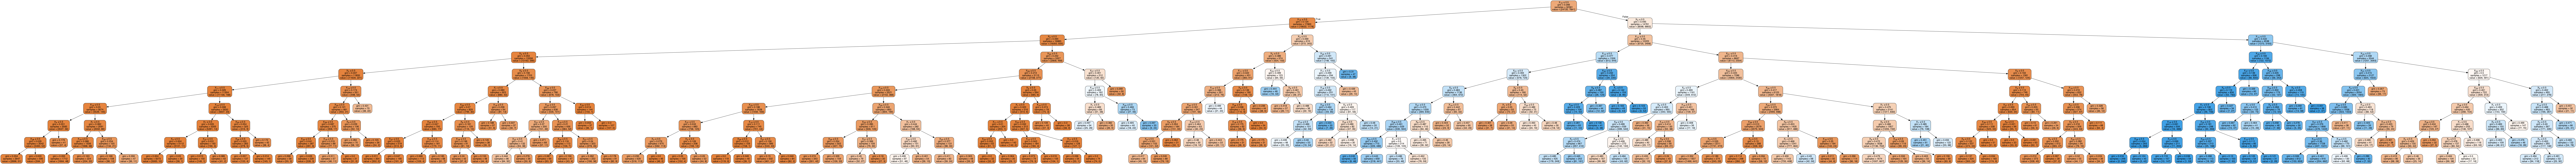

In [18]:
start = time.time()
best_dtree = DecisionTreeClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=30, max_depth=9)
best_dtree.fit(x_train,y_train)
# record the total time it takes to train the model
elapsed = time.time()-start
print("Total runtime to train the model is {}.".format(elapsed))

dot_data = StringIO()
export_graphviz(best_dtree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# 9. Automation of Performance Tuning

In [19]:
def tune_hyperparams(hyperparam_csv):
    # read csv file
    hp_df = pd.read_csv(hyperparam_csv)
    for i in hp_df.index:
        # instantiate the model using hyperparameters inside the dataframe
        dtree = DecisionTreeClassifier(random_state=23,
                                           criterion=hp_df.loc[i,'Split Criteria (Entropy or Gini)'], 
                                           min_samples_split=hp_df.loc[i,'Minimum Sample Split'],
                                           min_samples_leaf=hp_df.loc[i,'Minimum Sample Leaf'],
                                           max_depth=hp_df.loc[i,'Maximum Depth'])
        dtree.fit(x_train, y_train) # fit the training data
        y_pred = dtree.predict(x_test) # predict the test data
        # create a list of all the performance measures: precision, recall, f-score, support
        measures = precision_recall_fscore_support(y_test,y_pred)
        # put in all the performance measures into the dataframe
        hp_df.loc[i,'Accuracy'] = np.round(accuracy_score(y_test,y_pred),2)
        hp_df.loc[i,'Recall'] = np.round(measures[1][1],2)
        hp_df.loc[i,'Precision'] = np.round(measures[0][1],2)
        hp_df.loc[i,'F1 Score'] = np.round(measures[2][1],2)
    return hp_df

tune_hyperparams('hyperparams.csv')

Split Criteria (Entropy or Gini)  Minimum Sample Split  Minimum Sample Leaf  \
0                          entropy                    15                   20   
1                          entropy                    12                   18   
2                          entropy                     7                   25   
3                          entropy                    10                   30   
4                             gini                    15                   20   
5                             gini                    12                   18   
6                             gini                     7                   25   
7                             gini                    10                   30   

   Maximum Depth  Accuracy  Recall  Precision  F1 Score  
0              8      0.84    0.56       0.71      0.63  
1              6      0.84    0.59       0.68      0.63  
2              7      0.84    0.57       0.71      0.63  
3              9      0.84    0.58       0.70      0.63  
4              8      0.84    0.56       0.72      0.63  
5              6      0.84    0.59       0.69      0.63  
6              7      0.84    0.58       0.70      0.64  
7              9      0.84    0.58       0.71      0.64

# 10. Prediction Using Trained Decision Tree Model

In [20]:
new_person = encoder.transform([['41-50 & 61-70','Mid - Low','High','> 0','Mid','High','income','36-40 & 56-60']]).toarray()

In [21]:
# predict the target class of the new individual
new_person_pred = best_dtree.predict(new_person)
print(new_person_pred)
# label of 1 means that the predicted income category for this individual is >50K

[1]
